In [26]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from modules import train_model, test_model
from dataset import BPDataset, MIMICDataset, DMDataset
from torch import optim
from torch.optim import lr_scheduler
from datetime import datetime
import pandas as pd
from backbone_models import ResNet18, VGG16, shallowResNet, shallowResNet2,ResNet3, FCNet, Conv3Net
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
ppg_dir = '/Users/yeseullee/Documents/ECE271B/PPGBPDatabase/Data File/0_subject'
label_path = '/Users/yeseullee/Documents/ECE271B/PPGBPDatabase/Data File/PPG-BP dataset.csv'

In [28]:
##Calculate Dataset's mean and std for normalization - Before preprocessed
'''temp_dataset=MIMICDataset(data_path, label_path,choose_class=[0,1,2])
temp_size=temp_dataset.__len__()
temp_dataloader=torch.utils.data.DataLoader(temp_dataset,batch_size=temp_size,shuffle=False)
for data, label, sub in temp_dataloader:
    flatten_data=np.array(data.flatten())
    mean=np.mean(flatten_data)
    std=np.std(flatten_data)
    print('- mean: ',mean)
    print('- std: ',std)'''

"temp_dataset=MIMICDataset(data_path, label_path,choose_class=[0,1,2])\ntemp_size=temp_dataset.__len__()\ntemp_dataloader=torch.utils.data.DataLoader(temp_dataset,batch_size=temp_size,shuffle=False)\nfor data, label, sub in temp_dataloader:\n    flatten_data=np.array(data.flatten())\n    mean=np.mean(flatten_data)\n    std=np.std(flatten_data)\n    print('- mean: ',mean)\n    print('- std: ',std)"

In [29]:
##Calculate Dataset's mean and std for normalization - After preprocessed
'''temp_dataset=MIMICDataset(data_path, label_path,normalize=None, preprocessing=True, choose_class=[0,1,2])
temp_size=temp_dataset.__len__()
temp_dataloader=torch.utils.data.DataLoader(temp_dataset,batch_size=temp_size,shuffle=False)
for data, label, sub in temp_dataloader:
    flatten_data=np.array(data.flatten())
    mean=np.mean(flatten_data)
    std=np.std(flatten_data)
    print('- mean: ',mean)
    print('- std: ',std)'''

"temp_dataset=MIMICDataset(data_path, label_path,normalize=None, preprocessing=True, choose_class=[0,1,2])\ntemp_size=temp_dataset.__len__()\ntemp_dataloader=torch.utils.data.DataLoader(temp_dataset,batch_size=temp_size,shuffle=False)\nfor data, label, sub in temp_dataloader:\n    flatten_data=np.array(data.flatten())\n    mean=np.mean(flatten_data)\n    std=np.std(flatten_data)\n    print('- mean: ',mean)\n    print('- std: ',std)"

In [30]:
data_mean=2060.61
data_std=285.13
data_normalization = {'mean':data_mean,'std':data_std}

# setup data loader
dataset = DMDataset(ppg_dir, label_path, normalize=data_normalization,preprocessing=False)
dataset_size=dataset.__len__()
print('dataset: {}'.format(dataset.__len__()))

dataset: 648


In [31]:
training_size=int(dataset_size*0.64)
test_size=int(dataset_size*0.2)
val_size=dataset_size-training_size-test_size

In [36]:
# Split training data, validation data, testing data
data_train, data_val, data_test = torch.utils.data.random_split(dataset, [training_size, val_size, test_size])
print(data_train.__len__())
print(data_val.__len__())
print(data_test.__len__())

414
105
129


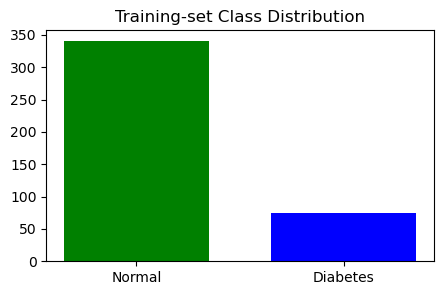

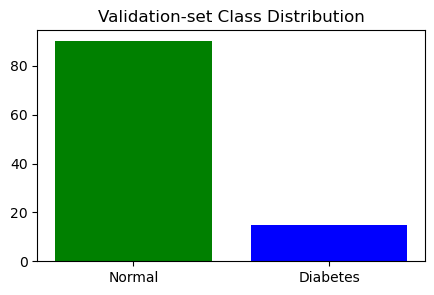

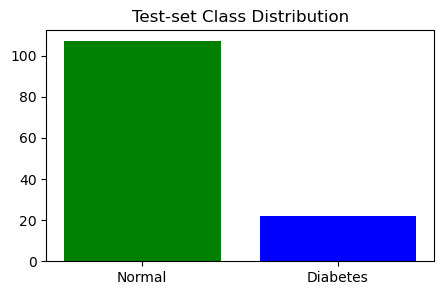

In [37]:
temp_dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=1,shuffle=False),
                'val':torch.utils.data.DataLoader(data_val,batch_size=1,shuffle=False),
                'test':torch.utils.data.DataLoader(data_test,batch_size=1,shuffle=False)}

train_labels=[0,0]
for data, label, subject in temp_dataloaders['train']:
    if label.data==0:
        train_labels[0]+=1
    elif label.data==1:
        train_labels[1]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(2),train_labels,color=['g','b'],width=0.7)
plt.xticks(np.arange(2),['Normal','Diabetes'])
plt.title('Training-set Class Distribution')
plt.show()

val_labels=[0,0]
for data, label, subject in temp_dataloaders['val']:
    if label.data==0:
        val_labels[0]+=1
    elif label.data==1:
        val_labels[1]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(2),val_labels,color=['g','b'])
plt.xticks(np.arange(2),['Normal','Diabetes'])
plt.title('Validation-set Class Distribution')
plt.show()

test_labels=[0,0]
for data, label, subject in temp_dataloaders['test']:
    if label.data==0:
        test_labels[0]+=1
    elif label.data==1:
        test_labels[1]+=1

plt.figure(figsize=(5,3))
plt.bar(np.arange(2),test_labels,color=['g','b'])
plt.xticks(np.arange(2),['Normal','Diabetes'])
plt.title('Test-set Class Distribution')
plt.show()

In [38]:
dataloaders={'train': torch.utils.data.DataLoader(data_train,batch_size=16,shuffle=True),
                'val':torch.utils.data.DataLoader(data_val,batch_size=16,shuffle=True),
                'test':torch.utils.data.DataLoader(data_test,batch_size=16,shuffle=False)}
dataset_sizes = {'train': data_train.__len__(),
                    'val':data_val.__len__(),
                    'test':data_test.__len__()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)

Device: cpu


In [40]:
class Conv3Net2(nn.Module):
    def __init__(self, n_class=2):
        super(Conv3Net2, self).__init__()
        self.n_class = n_class
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=30, stride=3, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=15, stride=3, padding=2),
            #nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            #nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, n_class)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [41]:
model=Conv3Net2(2)
model=model.to(device)

In [ ]:
model

Epoch 0/149
----------
train Loss: 0.5459 Acc: 0.8140
val Loss: 0.4865 Acc: 0.8286

Epoch 1/149
----------
train Loss: 0.4850 Acc: 0.8309
val Loss: 0.4691 Acc: 0.8286

Epoch 2/149
----------
train Loss: 0.4664 Acc: 0.8309
val Loss: 0.4592 Acc: 0.8286

Epoch 3/149
----------
train Loss: 0.4572 Acc: 0.8309
val Loss: 0.4566 Acc: 0.8286

Epoch 4/149
----------
train Loss: 0.4561 Acc: 0.8309
val Loss: 0.4559 Acc: 0.8286

Epoch 5/149
----------
train Loss: 0.4527 Acc: 0.8309
val Loss: 0.4491 Acc: 0.8286

Epoch 6/149
----------
train Loss: 0.4514 Acc: 0.8309
val Loss: 0.4488 Acc: 0.8286

Epoch 7/149
----------
train Loss: 0.4429 Acc: 0.8309
val Loss: 0.4388 Acc: 0.8286

Epoch 8/149
----------
train Loss: 0.4354 Acc: 0.8382
val Loss: 0.4358 Acc: 0.8286

Epoch 9/149
----------
train Loss: 0.4440 Acc: 0.8309
val Loss: 0.4312 Acc: 0.8286

Epoch 10/149
----------
train Loss: 0.4358 Acc: 0.8357
val Loss: 0.4363 Acc: 0.8286

Epoch 11/149
----------
train Loss: 0.4373 Acc: 0.8309
val Loss: 0.4327 Acc

train Loss: 0.3332 Acc: 0.8671
val Loss: 0.4290 Acc: 0.8095

Epoch 98/149
----------
train Loss: 0.3372 Acc: 0.8599
val Loss: 0.4284 Acc: 0.8095

Epoch 99/149
----------
train Loss: 0.3509 Acc: 0.8551
val Loss: 0.4287 Acc: 0.8000

Epoch 100/149
----------
train Loss: 0.3367 Acc: 0.8623
val Loss: 0.4287 Acc: 0.8000

Epoch 101/149
----------
train Loss: 0.3320 Acc: 0.8671
val Loss: 0.4288 Acc: 0.8095

Epoch 102/149
----------
train Loss: 0.3189 Acc: 0.8671
val Loss: 0.4292 Acc: 0.8095

Epoch 103/149
----------
train Loss: 0.3374 Acc: 0.8527
val Loss: 0.4298 Acc: 0.8095

Epoch 104/149
----------
train Loss: 0.3325 Acc: 0.8647
val Loss: 0.4297 Acc: 0.8095

Epoch 105/149
----------
train Loss: 0.3378 Acc: 0.8599
val Loss: 0.4294 Acc: 0.8095

Epoch 106/149
----------
train Loss: 0.3348 Acc: 0.8647
val Loss: 0.4296 Acc: 0.8000

Epoch 107/149
----------
train Loss: 0.3279 Acc: 0.8575
val Loss: 0.4291 Acc: 0.8095

Epoch 108/149
----------
train Loss: 0.3329 Acc: 0.8502
val Loss: 0.4289 Acc: 0.8

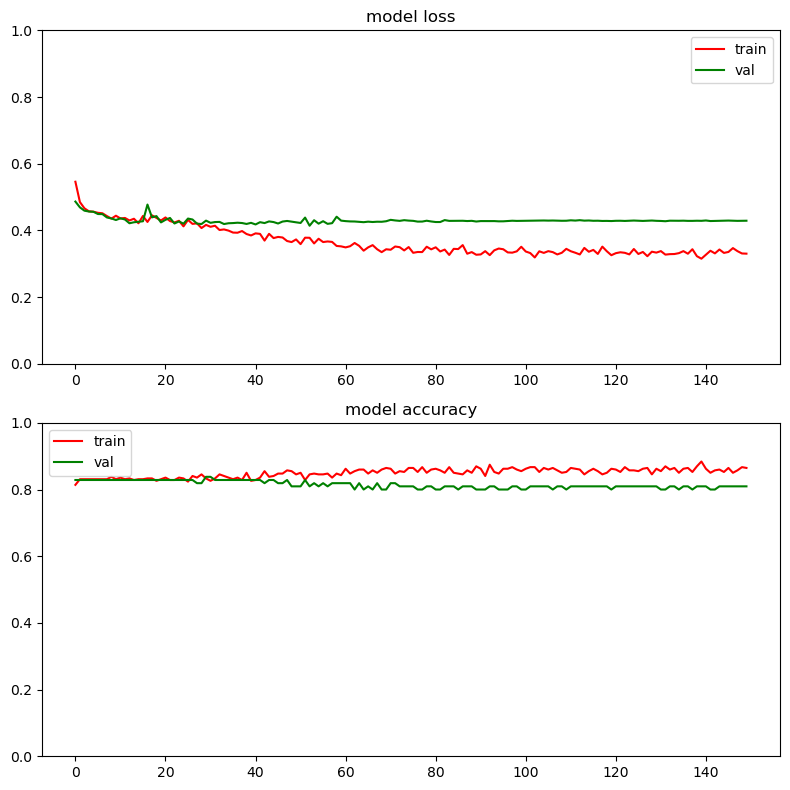

In [24]:
#learning_rate=0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=0.01
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)
trained_model,trained_model_later=train_model(model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes, device, num_epochs=150)

In [25]:
from sklearn.metrics import confusion_matrix

def test_model(model,dataloaders,dataset_size,classes,device):
    
    model=model.to(device)
    model.eval()
    corrects=0
    CM=0
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels, subject= data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images) 
            preds = torch.argmax(outputs.data, 1)

            cm_tmp=confusion_matrix(labels.tolist(), preds.tolist(),labels=classes)
            CM+=cm_tmp
            
            corrects += torch.sum(preds == labels.data)
        tn=CM[0][0]
        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]
        
        sensitivity=tp/(tp+fn)
        precision=tp/(tp+fp)    
        acc=corrects.double() / dataset_size
        
        print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
        print('Confusion Matrix: ')
        print(CM)
        print('- Sensitivity : ',(tp/(tp+fn))*100)
        print('- Specificity : ',(tn/(tn+fp))*100)
        print('- Precision: ',(tp/(tp+fp))*100)
        print('- NPV: ',(tn/(tn+fn))*100)
        print('- F1 : ',((2*sensitivity*precision)/(sensitivity+precision))*100)
                
    return acc, CM

device_cpu=torch.device('cpu')

print('- model')
acc1,cm1=test_model(trained_model,dataloaders,dataset_sizes['test'],classes=[0,1], device=device)

print('- model_later')
acc2,cm2=test_model(trained_model_later,dataloaders,dataset_sizes['test'],classes=[0,1], device=device)

- model

Testset Accuracy(mean): 80.620155 %
Confusion Matrix: 
[[104   2]
 [ 23   0]]
- Sensitivity :  0.0
- Specificity :  98.11320754716981
- Precision:  0.0
- NPV:  81.88976377952756
- F1 :  nan
- model_later

Testset Accuracy(mean): 82.170543 %
Confusion Matrix: 
[[106   0]
 [ 23   0]]
- Sensitivity :  0.0
- Specificity :  100.0
- Precision:  nan
- NPV:  82.17054263565892
- F1 :  nan


/Users/yeseullee/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/Users/yeseullee/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/Users/yeseullee/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


In [58]:
model_path='/Users/yeseullee/Documents/ECE271B/project/models/'
model_name='shallowPPG_MIMIC[0,2]_'
torch.save(trained_model.state_dict(),model_path+model_name+datetime.today().strftime('%m-%d-%H:%M')+'.pt')